In [11]:
import sys
import os.path as op
import os
sys.path.append('/data_nfs/og86asub/netmap/netmap-evaluation/')

from netmap.src.utils.netmap_config import NetmapConfig
from src.methods.csnet.csnet_config import CsNetConfig
from src.data_simulation.data_simulation_config import DataSimulationConfig
from src.pipelines.utils import PipelineConfig
from captum.attr import GradientShap


import anndata
import numpy as np
import scanpy as sc
import pandas as pd
from sklearn.metrics.cluster import contingency_matrix
from scipy.optimize import linear_sum_assignment
import scipy.sparse as scs
from sklearn.cluster import SpectralClustering

from src.utils import write_config

import numpy as np
import pandas as pd
from typing import Optional
import itertools
import warnings


In [12]:
from netmap.src.downstream.downstream import *
from netmap.src.downstream.edge_selection import *

In [37]:
dataset_config = "/data_nfs/og86asub/netmap/netmap-evaluation/results/configurations/data_simulation/config_three/net_141_1664_net_61_687_net_70_1634_net_51_844.config.yaml"
netmap_config = '/data_nfs/og86asub/netmap/netmap-evaluation/results/netmap/config_9/config_three/net_141_1664_net_61_687_net_70_1634_net_51_844/config.yaml'
dataset_config =DataSimulationConfig.read_yaml(dataset_config)

config_dict = {}
config_dict['config_4'] = NetmapConfig.read_yaml(netmap_config)
c = 'config_4'
grn_adata =  sc.read_h5ad(op.join(config_dict[c].output_directory, config_dict[c].adata_filename))
ref_adata = sc.read_h5ad(config_dict[c].input_data)





{'input_data': '/data_nfs/og86asub/netmap/netmap-evaluation/data/simulated_data/config_three/net_141_1664_net_61_687_net_70_1634_net_51_844/data.h5ad', 'layer': 'X', 'output_directory': '/data_nfs/og86asub/netmap/netmap-evaluation/results/netmap/config_9/config_three/net_141_1664_net_61_687_net_70_1634_net_51_844', 'transcription_factors': '/data_nfs/datasets/SCENIC_DB/tf_lists/allTFs_hg38.txt', 'tf_only': False, 'penalize_error': True, 'adata_filename': 'grn_lrp.h5ad', 'grn': 'grn_lrp.tsv', 'masking_percentage': 0.1, 'print_every': 100, 'optimizer': 'Adam', 'learning_rate': 0.005, 'epochs': 10000, 'n_models': 10, 'validation_size': 0.2, 'model': 'ZINBAutoencoder', 'xai_method': 'GuidedBackprop', 'aggregation_strategy': 'mean'}


In [38]:
ref_adata

AnnData object with n_obs × n_vars = 1500 × 323
    obs: 'cell_id', 'depth', 'grn'
    var: 'genes'

In [39]:

grn_adata = add_top_edge_annotation_global(grn_adata, top_edges=[0.1], nan_fill=0)

[0.1]


In [40]:
323*323

104329

In [41]:
grn_adata.var

,source,target,global_cell_count_0.1
edge_key,,,
AAR2_AAR2,AAR2,AAR2,256.0
AAR2_ACOT11,AAR2,ACOT11,0.0
AAR2_ACOT8,AAR2,ACOT8,120.0
AAR2_ACVR1,AAR2,ACVR1,0.0
AAR2_ADRA1D,AAR2,ADRA1D,0.0
...,...,...,...
hsa-miR-93_ZNF541,hsa-miR-93,ZNF541,0.0
hsa-miR-93_ZNRF2,hsa-miR-93,ZNRF2,0.0
hsa-miR-93_ZSCAN10,hsa-miR-93,ZSCAN10,0.0


In [42]:
# preprocess GRN anndata object
grn_adata_filtered = grn_adata[:, grn_adata.var['global_cell_count_0.1']>0].copy()
grn_adata_filtered = process(grn_adata=grn_adata_filtered, n_clu=3, key_added = 'spectral')

clustering: 3 clusters


/data_nfs/og86asub/netmap/netmap-evaluation/netmap/.pixi/envs/default/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [46]:
grn_adata_filtered = add_top_edge_annotation_cluster(grn_adata_filtered, top_edges=[0.2], nan_fill=0)

[0.2]
[0.2]
[0.2]


In [47]:
grn_adata_filtered.var

,source,target,global_cell_count_0.1,n_cells,cell_count_1.0_1,cell_count_1.0_2,cell_count_1.0_0,cell_count_0.2_1,cell_count_0.2_2,cell_count_0.2_0
edge_key,,,,,,,,,,
AAR2_AAR2,AAR2,AAR2,256.0,1500,699,500,301,622.0,268.0,99.0
AAR2_ACOT8,AAR2,ACOT8,120.0,1430,699,500,301,247.0,1.0,298.0
AAR2_AMBN,AAR2,AMBN,1.0,857,699,500,301,5.0,60.0,129.0
AAR2_ANKRD2,AAR2,ANKRD2,488.0,548,699,500,301,95.0,0.0,128.0
AAR2_ARID1A,AAR2,ARID1A,317.0,1500,699,500,301,699.0,500.0,301.0
...,...,...,...,...,...,...,...,...,...,...
hsa-miR-93_XPO1,hsa-miR-93,XPO1,298.0,614,699,500,301,0.0,0.0,0.0
hsa-miR-93_ZFP42,hsa-miR-93,ZFP42,292.0,1495,699,500,301,0.0,0.0,0.0
hsa-miR-93_ZHX2,hsa-miR-93,ZHX2,257.0,1449,699,500,301,363.0,299.0,47.0


In [28]:
grn_adata.obs['grn'] = pd.Categorical(ref_adata.obs['grn'])

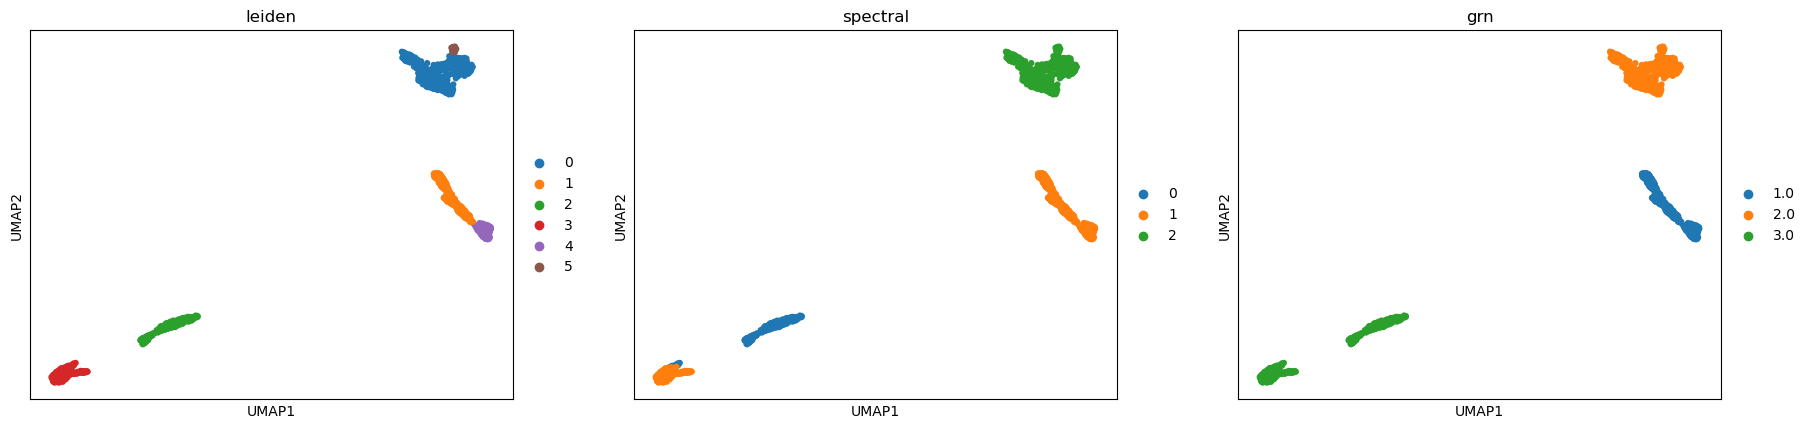

In [29]:
sc.pl.umap(grn_adata, color = ['leiden', 'spectral', 'grn'])